In [1]:
import os
from os import listdir
from os.path import isfile, join
# For data processing
import pandas as pd
import datetime as dt

# Matrix math
import numpy as np
import math

# For unnesting nested list/array
from itertools import chain

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#for logging
from time import time
import datetime as dt

#plotting
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns

import operator
from functools import reduce
import winsound

In [2]:
BLOCK = 'B'
df = pd.read_csv("Feat_Eng_B.csv", sep="\t", encoding='utf-8')
df.drop('Unnamed: 0', axis = 1, inplace=True)
# Drop Acorn as this can already be inferred
df.drop('Acorn', axis = 1, inplace=True)
# Drop variables due to missing data
df.drop('cloudCover',axis=1,inplace=True)
df.drop('dewPoint',axis=1,inplace=True)
df.drop('apparentTemperature',axis=1,inplace=True)
df.drop('visibility',axis=1,inplace=True)
df.drop('windSpeed',axis=1,inplace=True)
df.drop('windBearing',axis=1,inplace=True)
# Drop variables deemed irrelevant by statistical analysis
df.drop('pressure', axis=1, inplace=True)
# Sort values by smart meter
df = df[(df['Year'] < 2014) | ((df['Year'] == 2014) & (df['Month'] == 1) & (df['Day'] == 1) & (df['Hour'] < 1.5))]
df['LCLid'] = df['LCLid'].apply(str)
df = df[df['LCLid'] != '0']
df.reset_index(inplace=True, drop=True)

In [3]:
def model_data(raw_data, timestamps, days):
    # Amount of data that is used for training prediction
    sequence_length = days*48
    # Number of ending, up to, index for testing
    window_length = sequence_length+48
    #Convert the file to a list
    data = np.array(raw_data.tolist())  
    X_train = data[0:sequence_length, 0:len(data[0])-1]
    y_train = data[0:sequence_length, len(data[0])-1]
    X_test = data[sequence_length:window_length, 0:len(data[0])-1]
    y_test = data[sequence_length:window_length,len(data[0])-1]
    timestamps_test = timestamps[sequence_length:window_length]
    return X_train, y_train, X_test, y_test, list(timestamps_test)

In [4]:
def arima_1_lvl(df, train_days, test_days):
    df = df.values
    # Initialize predictions list
    predictions = []
    timestamps = df[:,0]
    #Record the time the model starts training
    start = time()
    # Initialize iteration value
    i = 0
    while i < test_days:
        X_train, y_train, X_test, y_test, timestamps_test = model_data(df[:,1:], timestamps, 31)
        for t in range(len(y_test)):
            yhat = ARIMA(np.float64(y_train), order=(0,0,1)).fit(disp=0).forecast()[0]
            if t == 0:
                predictions.append([yhat[0]+X_train[-1][0], np.float64(X_test[-1][t]), timestamps_test[t]])
            else:
                _ = yhat[0] + predictions[t-1][0]
                predictions.append([_, np.float64(X_test[t]), timestamps_test[t]])
        timestamps = timestamps[48:]
        df = df[48:]
        if i == 0:
            proc_time = int(math.floor(time() - start))
            print('1-level predictions for ', BLOCK, ' for ', i, ' days in ', proc_time, ' seconds')
        if i % 30 == 0:
            print('Epoch: ',i)
        i += 1
    proc_time = int(math.floor(time() - start))
    print('1-level ARIMA predictions for ', BLOCK, ' takes ', proc_time, ' seconds, for ', i, ' days.')
    ## Merge Data
    predictions = np.array(predictions)
    pred_all = pd.DataFrame({'DateTime': predictions[:,2], 'y_test': predictions[:,1], 'y_hat':predictions[:,0]}) 
    pred_all.to_csv(("ARIMA_"+BLOCK+"_predictions.csv"), sep="\t", encoding='utf-8')
    return pred_all

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def calculate_statistics(y_predict, Y_test, correlate = False):
    #Get Mean Squared Error
    RMSE = math.sqrt(mean_squared_error(Y_test, y_predict))
    # Get Mean Absolute Error
    MAPE = mean_absolute_percentage_error(Y_test, y_predict)
    
    # empty value for corr
    corr = np.nan
    # conditional to execute correlation
    if correlate == True:
        # Get Pearson product-moment correlation coefficients
        corr = np.corrcoef(Y_test, y_predict)[1][0]**2
    return RMSE, MAPE, corr

## Define Functions

## ARIMA - Predictions

In [7]:
arima_df = df.groupby(['DateTime'], as_index=False).agg({"KWH_hh": "mean"})
# Impose stationarity
arima_df['change'] = arima_df["KWH_hh"].diff()
arima_df.iloc[0,2] = 0
arima_df.head()

,DateTime,KWH_hh,change
0,2012-11-01 00:00,0.2220,0.0000
1,2012-11-01 00:30,0.1902,-0.0318
2,2012-11-01 01:00,0.2036,0.0134
3,2012-11-01 01:30,0.1842,-0.0194
4,2012-11-01 02:00,0.1890,0.0048


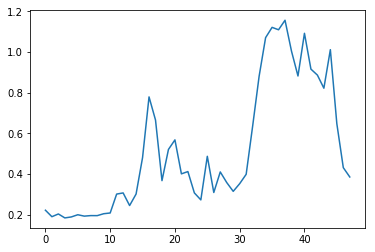

In [8]:
# Plot Actual data
plt.plot(arima_df.KWH_hh[0:48])

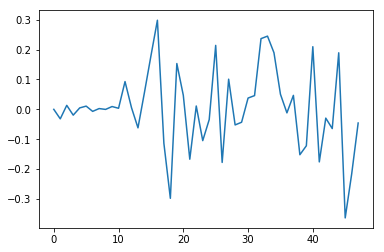

In [9]:
# Plot Stationarity
plt.plot(arima_df.change[0:48])

In [10]:
# Determine ARIMA properties
autocorrelation = arima_df.change.autocorr()
print("The autocorrelation is: ", autocorrelation)

The autocorrelation is:  -0.173595693982


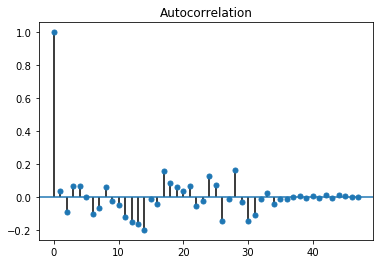

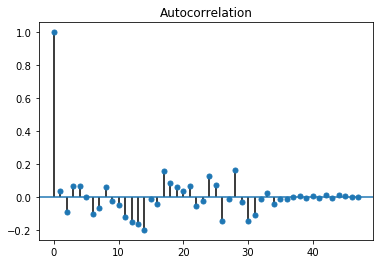

In [11]:
# Plot ACF - Autocorrelation function
plot_acf(arima_df.change[0:48], lags=47, alpha = 1)

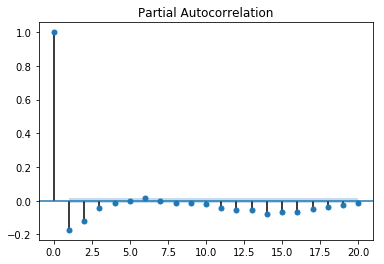

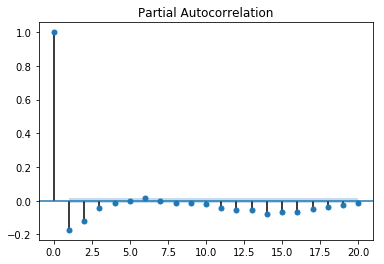

In [12]:
# Plot the PACF
plot_pacf(arima_df.change, lags=20)

In [13]:
# Compute and print ADF p-value
adf = adfuller(arima_df.change)
print("The p-value for the ADF test is <= ", adf[1])

The p-value for the ADF test is <=  0.0


In [14]:
# Model tends to have negative autocorrelation
arima_mod_results = arima_1_lvl(arima_df, 31, 364)

1-level predictions for  B  for  0  days in  1  seconds
Epoch:  0
Epoch:  30
Epoch:  60
Epoch:  90
Epoch:  120
Epoch:  150
Epoch:  180
Epoch:  210
Epoch:  240
Epoch:  270
Epoch:  300


C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gebruiker\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

Epoch:  330
Epoch:  360
1-level ARIMA predictions for  B  takes  527  seconds, for  364  days.


In [15]:
arima_RMSE, arima_MAPE, _ = calculate_statistics(arima_mod_results.y_hat.values.astype(float), arima_mod_results.y_test.values.astype(float), correlate = False)
print("Root Mean Squared Error:", arima_RMSE)
print("Mean Absolute Percentage Error:", arima_MAPE)

Root Mean Squared Error: 0.34395144484804235
Mean Absolute Percentage Error: 121.670528689


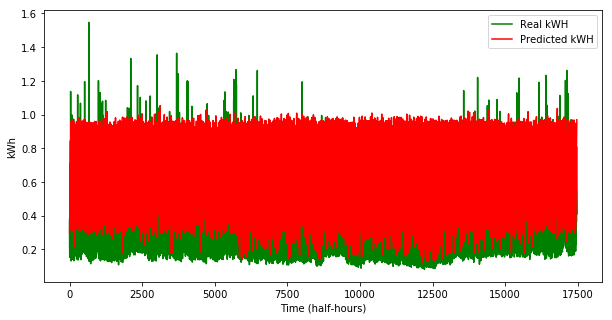

In [16]:
#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(arima_mod_results.y_test.values, color = 'green', label = 'Real kWH')
plt.plot(arima_mod_results.y_hat.values, color = 'red', label = 'Predicted kWH')
ax.set_ylabel("kWh")
ax.set_xlabel("Time (half-hours)")
ax.legend()

In [17]:
frequency = 800  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)